<a href="https://colab.research.google.com/github/SidharthBhakth/Generative-Models/blob/main/01_Image_Generation_with_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Generation with LSTMs**

In [ ]:
# Import libraries
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [ ]:
# Check if GPU is available
print(torch.cuda.is_available())

# Set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

False
cpu


In [ ]:
# Load MNIST data

# Train data
mnist_train = torchvision.datasets.MNIST('mnist', 
                                         train=True, 
                                       download=True,
                                       transform = transforms.ToTensor())


# Test data
mnist_test = torchvision.datasets.MNIST('mnist',
                                        train=False,
                                        download=True,
                                        transform = transforms.ToTensor())

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [ ]:
def make_patches(data_set, stride = 7, step = 7):

    X, Y, = [], []
    
    for image, _ in data_set:
        x = image.unsqueeze(1)
        x = x.unfold(2, stride, step).unfold(3, stride, step).reshape(-1, stride * step)
        X.append(x[0:15,:])
        Y.append(x[1:16,:])
    
    X, Y = torch.stack(X), torch.stack(Y)

    return TensorDataset(X.to(device), Y.to(device))

# Reference:
# https://stackoverflow.com/questions/53972159/how-does-pytorchs-fold-and-unfold-work
# https://discuss.pytorch.org/t/how-to-extract-smaller-image-patches-3d/16837/2

In [ ]:
train, test = random_split(mnist_train, [50000, 10000])

train_loader = DataLoader(make_patches(train), batch_size = 100)
val_loader = DataLoader(make_patches(mnist_test), batch_size = 100)

In [ ]:
## LSTM

class GenerativeLSTM(nn.Module):
    def __init__(self, input_size = 49, hidden_size = 128, num_layers = 2, out_features = 49):
        super(GenerativeLSTM, self).__init__()

        # Define parameters
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.num_layers = num_layers
        self.out_features = out_features

        # RNN layer
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)

        self.fc = nn.Sequential(nn.Linear(hidden_size, out_features),
                                nn.ReLU())
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)

        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        cell_state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        hidden = (hidden_state.to(device), cell_state.to(device))
        return hidden

# Instantiate neural network class
NN = GenerativeLSTM()
NN.to(device)

GenerativeLSTM(
  (rnn): LSTM(49, 128, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=49, bias=True)
    (1): ReLU()
  )
)

In [ ]:
def training_loop(lr=0.001, n_epochs = 100):

    # hyperparameters
    criterion = nn.MSELoss()
    optimizer = optim.Adam(NN.parameters(), lr)

    train_loss = []
    val_loss = []

    for epoch in range(1, n_epochs+1):

        running_loss = 0

        # Train
        NN.train()
        for X, Y in train_loader:
            optimizer.zero_grad()                                               # Set the parameter gradients to zero
            Y_hat, _ = NN(X)                                                    # Forward pass to predict sequence
            loss = criterion(Y_hat, Y)                                          # Compute loss on train data
            running_loss += loss.item()
            loss.backward()                                                     # Backpropagation
            optimizer.step()                                                    # Optimization
        
        # Keep track of train loss and SNR for each epoch
        train_loss.append(running_loss/len(train_loader))
        
        # Validate
        NN.eval()
        with torch.no_grad():
            running_loss = 0
            for X, Y in val_loader:
                Y_hat, _ = NN(X)                                                # Forward pass to predict sequence
                loss = criterion(Y_hat, Y)                                      # Compute loss on validation data
                running_loss += loss.item()

        # Keep track of validation loss and SNR for each epoch
        val_loss.append(running_loss/len(val_loader))

        if epoch%10 == 0:
            print(f"Epoch {epoch:3} | train loss: {train_loss[-1]:.4f}, validation loss: {val_loss[-1]:.4f}")
    
    return train_loss, val_loss

In [ ]:
train_loss, val_loss = training_loop()

Epoch  10 | train loss: 0.0293, validation loss: 0.0296
Epoch  20 | train loss: 0.0273, validation loss: 0.0284
Epoch  30 | train loss: 0.0263, validation loss: 0.0281
Epoch  40 | train loss: 0.0255, validation loss: 0.0280
Epoch  50 | train loss: 0.0249, validation loss: 0.0283
Epoch  60 | train loss: 0.0245, validation loss: 0.0286
Epoch  70 | train loss: 0.0241, validation loss: 0.0288
Epoch  80 | train loss: 0.0237, validation loss: 0.0293
Epoch  90 | train loss: 0.0234, validation loss: 0.0297
Epoch 100 | train loss: 0.0232, validation loss: 0.0300


In [ ]:
#plt.figure(figsize = (20,10))
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
def test_make_patches(data_set, stride = 7, step = 7):

    X, labels = [], [] 

    for image, label in data_set:
        x = image.unsqueeze(1)
        x = x.unfold(2, stride, step).unfold(3, stride, step).reshape(-1, stride * step)
        X.append(x)
        labels.append(label)

    X, labels = torch.stack(X), torch.Tensor(labels)

    return TensorDataset(X.to(device), labels)

In [ ]:
test_loader = DataLoader(test_make_patches(test), batch_size = 1)

In [ ]:
def reconstruct_image(image):
    for i in range(0, len(image)):
        array = np.zeros((28,28))
        array[:7,:7] = image[0].reshape(7,7)
        array[:7,7:14] = image[1].reshape(7,7)
        array[:7,14:21] = image[2].reshape(7,7)
        array[:7,21:] = image[3].reshape(7,7)
        array[7:14,:7] = image[4].reshape(7,7)
        array[7:14,7:14] = image[5].reshape(7,7)
        array[7:14,14:21] = image[6].reshape(7,7)
        array[7:14,21:] = image[7].reshape(7,7)
        array[14:21,:7] = image[8].reshape(7,7)
        array[14:21,7:14] = image[9].reshape(7,7)
        array[14:21,14:21] = image[10].reshape(7,7)
        array[14:21,21:] = image[11].reshape(7,7)
        array[21:,:7] = image[12].reshape(7,7)
        array[21:,7:14] = image[13].reshape(7,7)
        array[21:,14:21] = image[14].reshape(7,7)
        array[21:,21:] = image[15].reshape(7,7)

    return array

In [ ]:
def LSTM_generate():

    output = []

    NN.eval()
    with torch.no_grad():
        for idx, (image, label) in enumerate(test_loader, 1):

            X_upper, X_lower = image[:, :8, :], []

            out, hidden = NN(X_upper)
            out = out[:, -1, :].unsqueeze(0)
            X_lower.append(out)

            for i in range(7):
                out, hidden = NN.rnn(out, hidden)
                out = NN.fc(out)
                out = out[:, -1, :].unsqueeze(0)
                X_lower.append(out)
            
            image = reconstruct_image(image.squeeze().cpu().numpy())
            generated = reconstruct_image(torch.cat((X_upper, torch.cat(X_lower, dim = 1)), dim = 1).squeeze().cpu().numpy())
            label = int(label.item())

            output.append([image, generated, label])
            
            if idx%500 == 0:
                print(f"{idx:5}/10000 images processed.")
    
    return np.vstack(output)

In [ ]:
output = LSTM_generate()

  500/10000 images processed.
 1000/10000 images processed.
 1500/10000 images processed.
 2000/10000 images processed.
 2500/10000 images processed.
 3000/10000 images processed.
 3500/10000 images processed.
 4000/10000 images processed.
 4500/10000 images processed.
 5000/10000 images processed.
 5500/10000 images processed.
 6000/10000 images processed.
 6500/10000 images processed.
 7000/10000 images processed.
 7500/10000 images processed.
 8000/10000 images processed.
 8500/10000 images processed.
 9000/10000 images processed.
 9500/10000 images processed.
10000/10000 images processed.


In [ ]:
# randomly pick 10 images per class
indices = np.array([ np.argwhere(i==output[:,2])[:10] for i in np.unique(output[:, 2]) ])

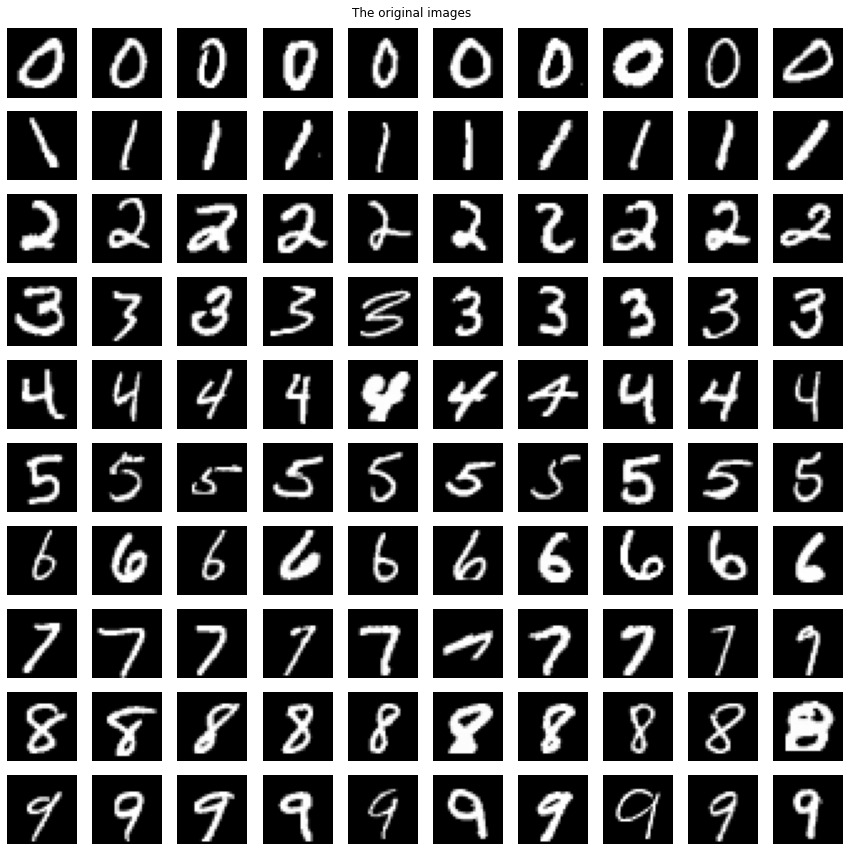

In [ ]:
fig, ax = plt.subplots(10, 10, figsize = (15,15))

for i in range(10):
    for j in range(10):
        idx = indices[i, j, :].item()
        image, _, _ = output[idx, :]
        ax[i, j].imshow(image, cmap ="gray")
        ax[i, j].axis('off')

fig.suptitle("The original images", y = 0.9)
plt.show()

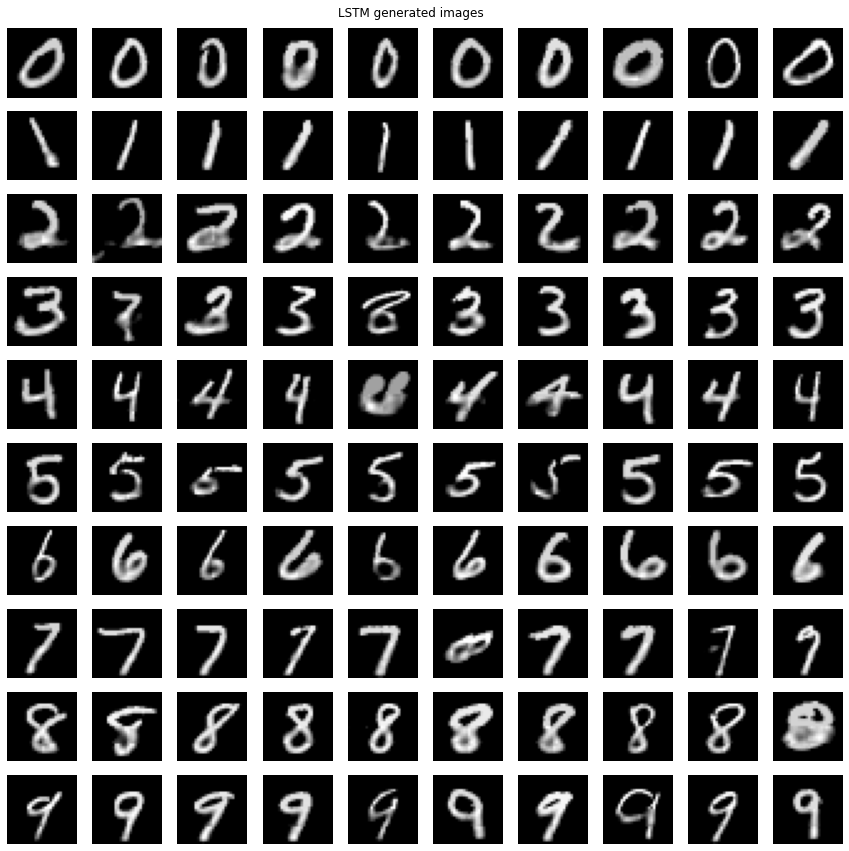

In [ ]:
fig, ax = plt.subplots(10, 10, figsize = (15,15))

for i in range(10):
    for j in range(10):
        idx = indices[i, j, :].item()
        _, generated, _ = output[idx, :]
        ax[i, j].imshow(generated, cmap ="gray")
        ax[i, j].axis('off')

fig.suptitle("LSTM generated images", y = 0.9)
plt.show()